## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.7f}'.format
pd.options.display.precision = 7
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## 1. Data Preparation

#### Load Data

In [3]:
df_all = pd.read_csv('./data/dialog_norm.csv')
df_all.columns

Index(['Instruction_id', 'category', 'selfdialog_norm'], dtype='object')

In [4]:
df_all.head(3)

,Instruction_id,category,selfdialog_norm
0,restaurant-table-2,0,hi im looking book table korean fod ok area thinking somewhere southern nyc maybe east village ok great theres thursday kitchen great reviews thats great need table tonight pm people dont want sit bar anywhere else fine dont availability pm times available yikes cant times ok second choice let check ok lets try boka free people yes great lets book ok great requests thats book great use account open yes please great get confirmation phone soon
1,movie-tickets-1,1,hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank enjoy movie
2,movie-tickets-3,2,want watch avengers endgame want watch bangkok close hotel currently staying sounds good time want watch movie oclock many tickets two use account already movie theater yes seems movie time lets watch another movie movie want watch lets watch train dragon newest one yes one dont think movie playing time either neither choices playing time want watch afraid longer interested watching movie well great day sir thank welcome


#### Get a Sample of records.

In [5]:
cat_id_df = df_all[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
cat_count = len(cat_id_df)
sample_size = 1000
sample_per_cat = sample_size//cat_count
print('sample_size: ', sample_size, 'sample_per_cat: ', sample_per_cat)

sample_size:  1000 sample_per_cat:  71


In [6]:
# Function to Get balanced Sample - Get a bit more than needed then down sample
def sampling_k_elements(group, k=sample_per_cat + 20):
    if len(group) < k:
        return group
    return group.sample(k, random_state=10)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to sample_size
corpus_df = corpus_df.sample(n=sample_size, random_state=3)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    74
coffee-ordering-1     79
coffee-ordering-2     71
movie-finder          41
movie-tickets-1       75
movie-tickets-2       72
movie-tickets-3       77
pizza-ordering-1      74
pizza-ordering-2      75
restaurant-table-1    71
restaurant-table-2    80
restaurant-table-3    63
uber-lyft-1           78
uber-lyft-2           70
dtype: int64


#### Generate Corpus List

In [7]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm)

print(len(doc_lst))
doc_lst[1:5]

1000


['hi starbucks coffee hi assist would like order iced black white mocha kind milk want whole milk want whipped cream whipped cream want whipped cream okanything specific nothing okyou pick order sec lincoln yosemite lone tree ok want make payment account starbucks okthen please provide account number details thanks come pick order come pick order min ok thanks anything else want thankshave good day good day',
 'hello want get uber would like go sumter mall city destination located sumter south carolina ok sumter mall located broad street sumter sc yes wish picked current location yes want use uber lift uber uber offer two options would like hear yes uber offers uberx current location uber xl would like repeat options would like first option first option uberx current location sumter mall broad street sumter south carolina would like order selection yes order created uber x ride current location sumter mall located broad street sumter sc cost correct say yes complete purchase yes order 

#### Split Data into Train and Test Sets

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

#### Build Vocabulary

In [9]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in X_train]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 5092
Vocabulary Sample: [('like', 1), ('would', 2), ('ok', 3), ('okay', 4), ('yes', 5), ('want', 6), ('pm', 7), ('order', 8), ('time', 9), ('please', 10)]


## Bag of Words Feature Extraction

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(X_train, y_train)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 2, 3, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 3, 3, ..., 0, 0, 1]], dtype=int64)

In [11]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,ok,okay,yes,want,pm,order,time,please,thank,one,tickets,need,...,doogle,tuneup,battery,columbia,macguffins,expand,yyy,scanning,inquiry,ai,communicate,acknowledge,cross,shutdown,windshield
0,0,1,1,2,0,4,0,7,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,3,4,0,2,0,0,0,1,0,1,0,0,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,7,0,2,2,0,4,2,1,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,3,1,0,1,1,1,0,0,0,1,0,3,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,5,4,0,4,1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,0,0,1,3,0,4,3,0,0,3,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
746,0,0,0,0,1,0,6,0,5,2,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
747,0,1,1,0,0,4,0,2,0,0,1,0,0,5,1,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
748,0,0,0,0,0,9,1,0,4,0,8,2,1,0,0,...,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0


In [12]:
# Get BOW features
X_train_bow = cv_matrix #cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 5092)
(250, 5092)
(250,)


#### Define Model Builder Function

In [13]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

class Result_Metrics:
    def __init__(self, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()
    precision = metrics.precision_score(labels_test, pred, average='weighted')
    recall = metrics.recall_score(labels_test, pred, average='weighted')
    
    rm = Result_Metrics(pred, cm, report, f1, accuracy, precision, recall)

    return rm

## Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [14]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
rm_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [15]:

def Save_Benchmark(descr, feat_type, b_metrics, reset_rb, reset_rb_all):
    global rows_benchmarks
    global rows_benchmarks_all
    global df_benchmarks
    global df_benchmarks_all
    if (reset_rb):
        rows_benchmarks = []

    if (reset_rb_all):
        rows_benchmarks_all = []
    rows_benchmarks.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    rows_benchmarks_all.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])
    df_benchmarks_all = pd.DataFrame(rows_benchmarks_all, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])


In [16]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Baseline", "BOW", rm_nb_bow, True, True)
#df_benchmarks

In [17]:
from sklearn.metrics import confusion_matrix
#rm_nb_bow.cm

In [18]:
from sklearn import metrics
#print("Label" + rm_nb_bow.report)

## Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Functions

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

class Result_Metrics_selected:
    def __init__(self, x_train_sel, x_test_sel, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.x_train_sel = x_train_sel
        self.x_test_sel = x_test_sel
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Get_Scaled_Features(features_train, labels_train, features_test, labels_test, scaler):
    x_train_scaled = scaler.fit_transform(features_train, labels_train)
    x_test_scaled = scaler.transform(features_test)
    return x_train_scaled, x_test_scaled

def Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test):
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(features_train, labels_train)
    chi_support = chi_selector.get_support()    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    return X_train_chi, X_test_chi

def Get_Model_Feature_Metrics(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_train_chi, X_test_chi = Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test)
    x_train_scaled, x_test_scaled = Get_Scaled_Features(X_train_chi, labels_train, X_test_chi, labels_test, scaler)
    rm_chi = Build_Model(model, x_train_scaled, labels_train, x_test_scaled, labels_test)
    return rm_chi

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_norm = scaler.fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]

    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()
    precision_chi = metrics.precision_score(labels_test, predict_chi, average='weighted')
    recall_chi = metrics.recall_score(labels_test, predict_chi, average='weighted')
    
    rm_chi = Result_Metrics_selected(X_train_chi, X_test_chi, predict_chi, cm_chi, report_chi, f1_chi, accuracy_chi, precision_chi, recall_chi)

    return rm_chi

#### Iterate through number of features and get benchmark results

In [20]:
a = 100
tot = X_train_bow.shape[1]
b = 100 * (tot//100)
c = 100
print(a, b, c)

100 5000 100


In [21]:
rows = []

scaler_min_max = MinMaxScaler()
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

In [22]:
#acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [23]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

2650 2750 1


#### Get a more fine-grained look at the optimal number of features region

In [24]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [25]:
#acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [26]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

2700


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [27]:
model_nb_bow_opt = MultinomialNB()
rm_chi_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)

In [28]:
#print(rm_chi_opt_bow.cm)

In [29]:
#print("Label" + rm_chi_opt_bow.report)

In [30]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BOW", rm_chi_opt_bow, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.7565410,0.7280000,0.7247051,0.7280000
1,BOW Naive Bayes Optimal Features Selected: 2700,BOW,0.7496659,0.7120000,0.7080434,0.7120000


## Benchmark the following four models: Logistic Regression (Multinomial) Naive Bayes Linear Support Vector Machine Random Forest

#### Baseline Features

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, X_train_bow, y_train, scoring='f1_weighted', cv=CV)
    precisions = cross_val_score(model, X_train_bow, y_train, scoring='precision_weighted', cv=CV)
    recalls = cross_val_score(model, X_train_bow, y_train, scoring='recall_weighted', cv=CV)
    
    for i in range(0, 4, 1):
        entries.append((model_name, 'baseline', precisions[i], recalls[i], f1_scores[i]))

cv_df = pd.DataFrame(entries, columns=['model_name', 'features', 'precision', 'recall', 'f1_score'])       

#### Opimised Features

In [32]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
#entries = []

for model in models:
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='f1_weighted', cv=CV)
    precisions = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='precision_weighted', cv=CV)
    recalls = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='recall_weighted', cv=CV)

    for i in range(0, 4, 1):
        entries.append((model_name, 'optimized', precisions[i], recalls[i], f1_scores[i]))

cv_df = pd.DataFrame(entries, columns=['model_name', 'features', 'precision', 'recall', 'f1_score'])        

In [33]:

models_df = cv_df.groupby(['model_name','features']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

precision_mean  recall_mean  f1_score_mean
model_name             features                                             
LinearSVC              baseline        0.6517955    0.6383333      0.6342563
                       optimized       0.6815649    0.6716667      0.6678033
LogisticRegression     baseline        0.6776586    0.6633333      0.6616764
                       optimized       0.7113381    0.7016667      0.6996376
MultinomialNB          baseline        0.7228119    0.7033333      0.6984725
                       optimized       0.7867370    0.7616667      0.7549543
RandomForestClassifier baseline        0.5712969    0.5416667      0.4856746
                       optimized       0.5826754    0.5600000      0.4989128

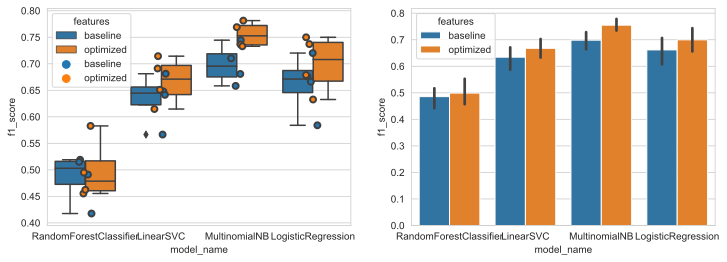

In [38]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)
sns.boxplot(x='model_name', y='f1_score', data=cv_df, hue='features', ax=ax1)
sns.stripplot(x='model_name', y='f1_score', data=cv_df, hue='features', size=6, jitter=True, edgecolor="gray", linewidth=2, ax=ax1)
sns.barplot(y='f1_score', x='model_name', data=cv_df, palette="colorblind", hue='features', ax=ax2)


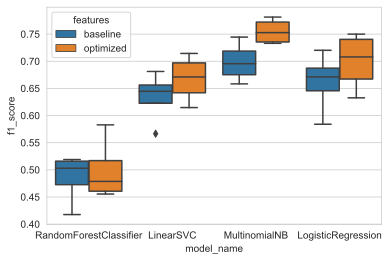

In [35]:
import seaborn as sns
sns.boxplot(x='model_name', y='f1_score', data=cv_df, hue='features')
#sns.stripplot(x='model_name', y='f1_score', data=cv_df, hue='features', size=6, jitter=True, edgecolor="gray", linewidth=2)

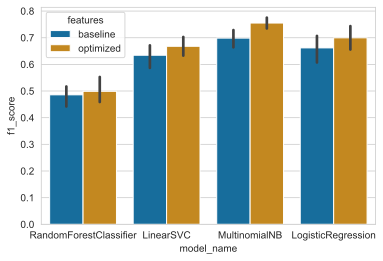

In [36]:
sns.barplot(y='f1_score', x='model_name', data=cv_df, palette="colorblind", hue='features')

In [37]:
import sklearn.metrics

#sorted(sklearn.metrics.SCORERS.keys())